D:\Users\fbasi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Users\fbasi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Users\fbasi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Users\fbasi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

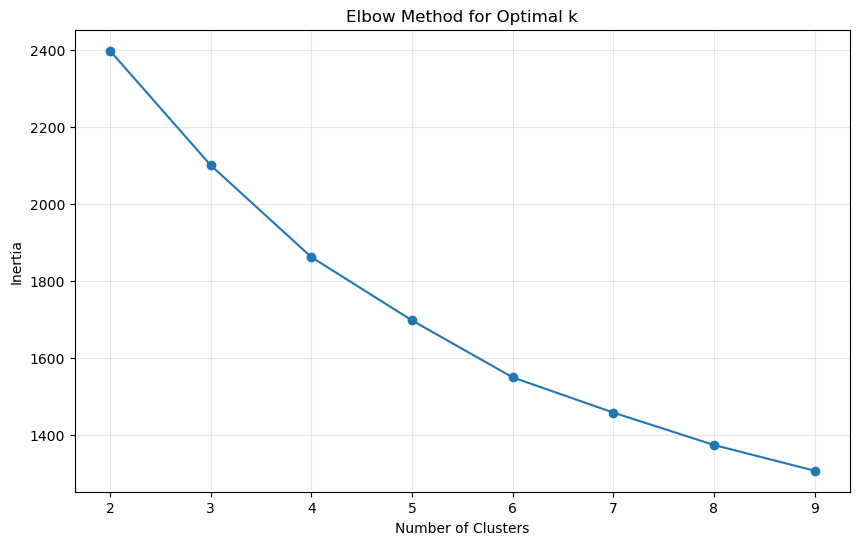

D:\Users\fbasi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


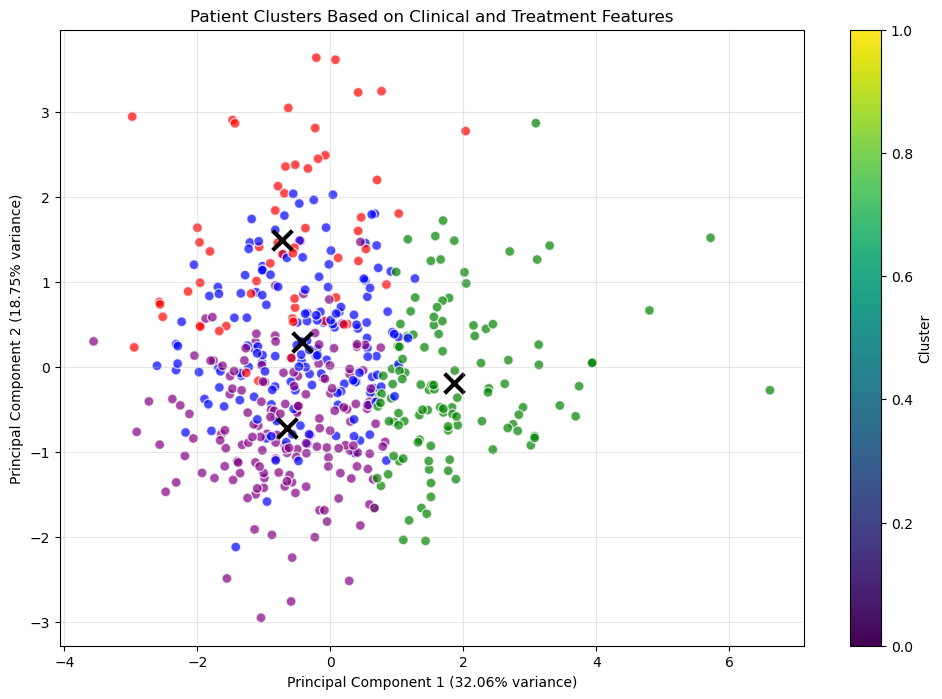


Cluster Characteristics:
               x1        x2        x4     age_s  time_on_regime    weight  \
cluster                                                                     
0       -0.288115  0.107642  0.216449  0.154321        0.351852  0.968681   
1        1.191478 -0.282651  0.546214 -0.094587        0.247863  1.284251   
2       -0.020880  0.147209  0.411564 -0.055556        2.416667  0.948384   
3       -0.546935  0.042233  0.754937  0.053002        0.273292  0.938927   

          outcome  treatment  censored  
cluster                                 
0        0.629630   0.419753  0.543210  
1        0.820513   0.572650  0.649573  
2        0.800000   0.533333  0.466667  
3        0.732919   0.422360  0.478261  


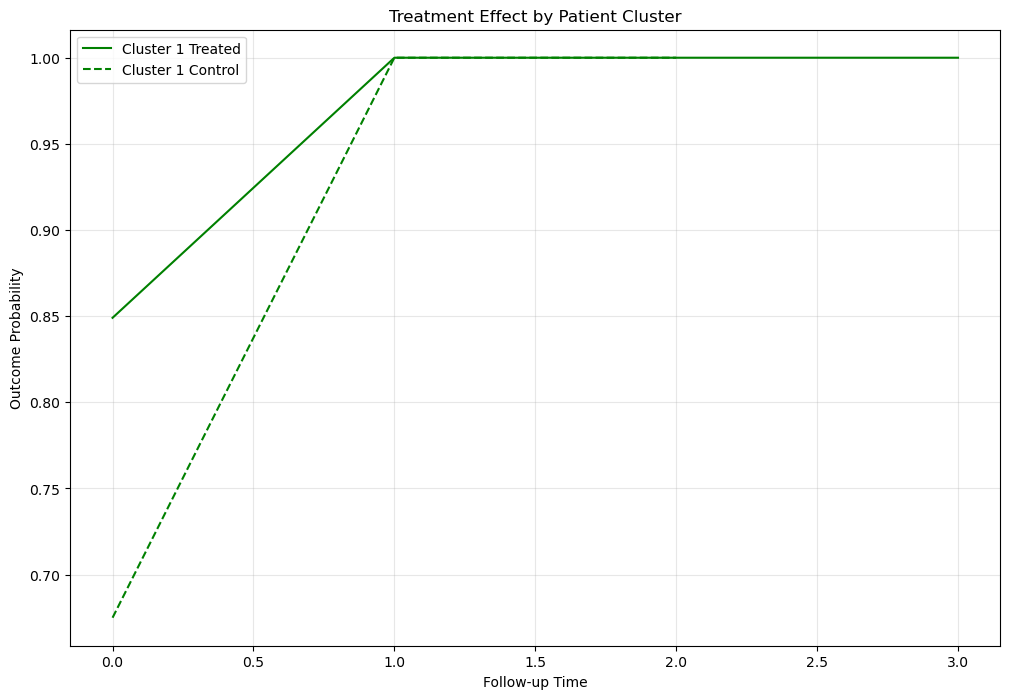


TTE Analysis by Cluster:

Cluster 0 (n=162):
Treatment Effect: 0.4382 (SE: 0.3626, p=0.2268)
95% CI: [-0.2725, 1.1489]

Cluster 1 (n=117):
Treatment Effect: 1.2562 (SE: 0.5144, p=0.0146)
95% CI: [0.2480, 2.2644]

Cluster 2 (n=60):
Treatment Effect: 0.5773 (SE: 0.7469, p=0.4396)
95% CI: [-0.8866, 2.0412]

Cluster 3 (n=161):
Treatment Effect: 0.1600 (SE: 0.4016, p=0.6903)
95% CI: [-0.6272, 0.9472]


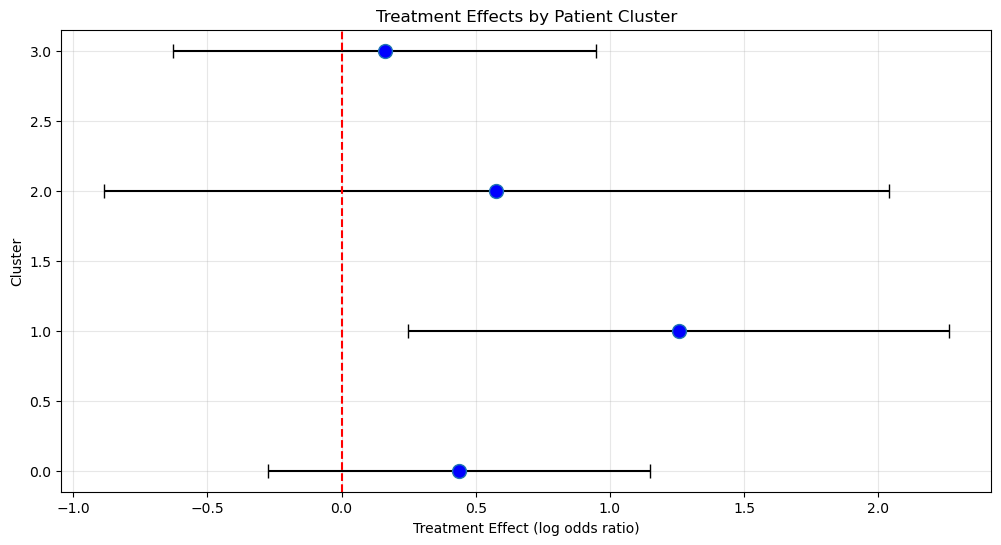


Key Insights from TTE + K-means Analysis:
- Cluster 1.0 shows the greatest treatment benefit (effect: 1.2562)
- Cluster 3.0 shows the least treatment benefit (effect: 0.1600)

Characteristics of cluster with maximum benefit:
x1                1.191478
x2               -0.282651
x4                0.546214
age_s            -0.094587
time_on_regime    0.247863
weight            1.284251
outcome           0.820513
treatment         0.572650
censored          0.649573
Name: 1, dtype: float64

Characteristics of cluster with minimum benefit:
x1               -0.546935
x2                0.042233
x4                0.754937
age_s             0.053002
time_on_regime    0.273292
weight            0.938927
outcome           0.732919
treatment         0.422360
censored          0.478261
Name: 3, dtype: float64


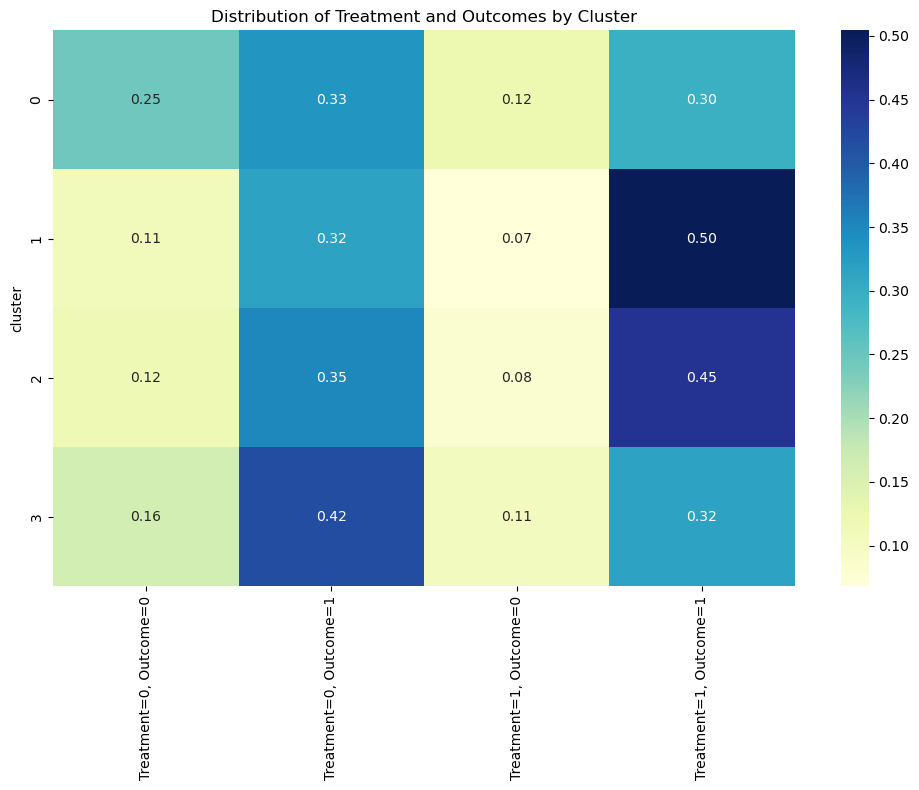

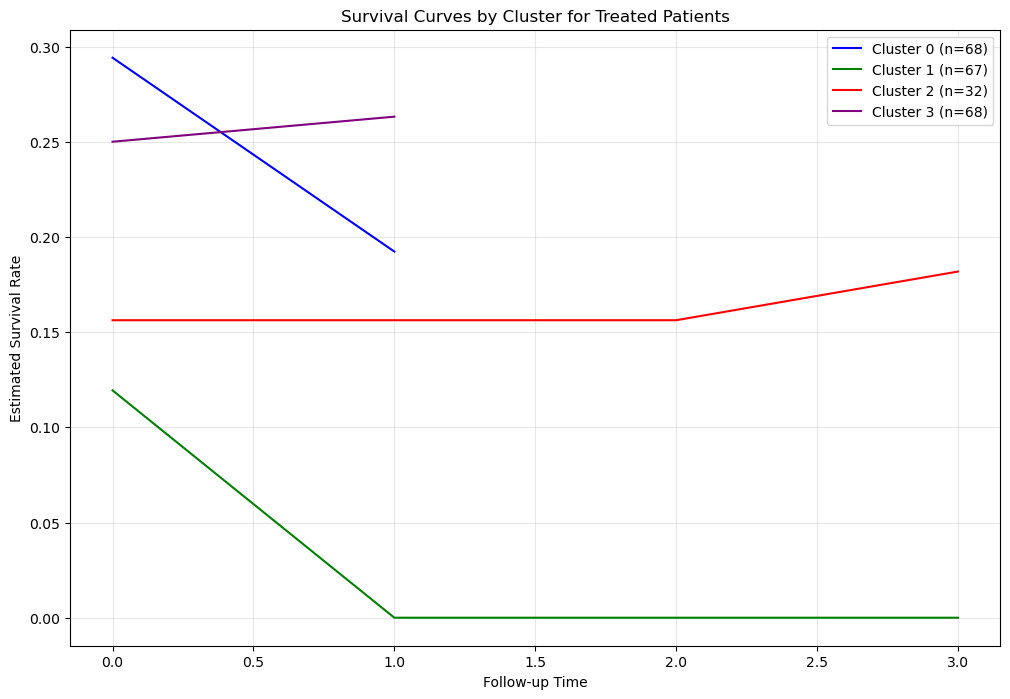

In [222]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"
from matplotlib.colors import ListedColormap

# Assuming data_censored is already loaded and preprocessed as in the original code
# Let's integrate K-means clustering with the TTE analysis

# 1. Select features for clustering
cluster_features = ['x1', 'x2', 'x4', 'age_s', 'time_on_regime', 'weight']

# 2. Standardize the features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_censored[cluster_features])

# 3. Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

# 4. Based on the elbow curve, choose optimal number of clusters
# For this implementation, let's use 4 clusters
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
data_censored['cluster'] = kmeans.fit_predict(scaled_features)

# 5. Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
data_censored['pca1'] = pca_result[:, 0]
data_censored['pca2'] = pca_result[:, 1]

plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive']
cmap = ListedColormap(colors[:n_clusters])

plt.scatter(data_censored['pca1'], data_censored['pca2'], 
            c=data_censored['cluster'], cmap=cmap, 
            alpha=0.7, s=50, edgecolors='w')

# Plot cluster centers
cluster_centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
            marker='x', s=200, linewidths=3, color='black')

plt.title('Patient Clusters Based on Clinical and Treatment Features')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# 6. Analyze cluster characteristics
cluster_stats = data_censored.groupby('cluster')[cluster_features + ['outcome', 'treatment', 'censored']].mean()
print("\nCluster Characteristics:")
print(cluster_stats)

# 7. Visualize treatment effect by cluster
plt.figure(figsize=(12, 8))
for cluster in range(n_clusters):
    cluster_data = data_censored[data_censored['cluster'] == cluster]
    
    # Treatment vs Control outcomes by follow-up time
    treated = cluster_data[cluster_data['treatment'] == 1].groupby('followup_time')['outcome'].mean()
    control = cluster_data[cluster_data['treatment'] == 0].groupby('followup_time')['outcome'].mean()
    
    # Only plot if we have enough data points
    if len(treated) > 2 and len(control) > 2:
        follow_up_times_treated = treated.index
        follow_up_times_control = control.index
        
        plt.plot(follow_up_times_treated, treated, 
                 label=f'Cluster {cluster} Treated', 
                 color=colors[cluster], 
                 linestyle='-')
        
        plt.plot(follow_up_times_control, control, 
                 label=f'Cluster {cluster} Control', 
                 color=colors[cluster], 
                 linestyle='--')

plt.xlabel('Follow-up Time')
plt.ylabel('Outcome Probability')
plt.title('Treatment Effect by Patient Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 8. Fit TTE models separately for each cluster
print("\nTTE Analysis by Cluster:")
treatment_effects = []

for cluster in range(n_clusters):
    cluster_data = data_censored[data_censored['cluster'] == cluster]
    
    # Only proceed if we have enough data points
    if len(cluster_data) > 30:  # Minimum sample size threshold
        # Fit model for this cluster
        cluster_model = sm.GLM(
            cluster_data["outcome"], 
            sm.add_constant(cluster_data[[
                "treatment",
                "x2", 
                "followup_time", 
                "I(followup_time^2)", 
                "trial_period", 
                "I(trial_period^2)"
            ]]),
            family=sm.families.Binomial(),
            freq_weights=cluster_data["modified_weight"]
        )
        
        try:
            cluster_model_fit = cluster_model.fit()
            
            # Extract treatment effect
            treatment_effect = cluster_model_fit.params['treatment']
            treatment_se = cluster_model_fit.bse['treatment']
            p_value = cluster_model_fit.pvalues['treatment']
            
            treatment_effects.append({
                'cluster': cluster,
                'n': len(cluster_data),
                'treatment_effect': treatment_effect,
                'se': treatment_se,
                'p_value': p_value,
                'ci_lower': treatment_effect - 1.96 * treatment_se,
                'ci_upper': treatment_effect + 1.96 * treatment_se
            })
            
            print(f"\nCluster {cluster} (n={len(cluster_data)}):")
            print(f"Treatment Effect: {treatment_effect:.4f} (SE: {treatment_se:.4f}, p={p_value:.4f})")
            print(f"95% CI: [{treatment_effect - 1.96 * treatment_se:.4f}, {treatment_effect + 1.96 * treatment_se:.4f}]")
            
        except:
            print(f"\nCluster {cluster}: Insufficient data for modeling")
    else:
        print(f"\nCluster {cluster}: Not enough data points (n={len(cluster_data)})")

# 9. Visualize treatment effects by cluster
if treatment_effects:
    effect_df = pd.DataFrame(treatment_effects)
    
    plt.figure(figsize=(12, 6))
    
    # Forest plot of treatment effects
    plt.errorbar(
        effect_df['treatment_effect'], 
        effect_df['cluster'],
        xerr=1.96 * effect_df['se'],
        fmt='o',
        capsize=5,
        ecolor='black',
        markersize=10,
        markerfacecolor='blue'
    )
    
    # Add vertical line at zero
    plt.axvline(x=0, color='red', linestyle='--')
    
    plt.title('Treatment Effects by Patient Cluster')
    plt.xlabel('Treatment Effect (log odds ratio)')
    plt.ylabel('Cluster')
    plt.grid(True, alpha=0.3)
    plt.show()

    # 10. Final insights: identify which types of patients benefit most from treatment
    max_benefit_cluster = effect_df.loc[effect_df['treatment_effect'].idxmax()]
    min_benefit_cluster = effect_df.loc[effect_df['treatment_effect'].idxmin()]
    
    print("\nKey Insights from TTE + K-means Analysis:")
    print(f"- Cluster {max_benefit_cluster['cluster']} shows the greatest treatment benefit (effect: {max_benefit_cluster['treatment_effect']:.4f})")
    print(f"- Cluster {min_benefit_cluster['cluster']} shows the least treatment benefit (effect: {min_benefit_cluster['treatment_effect']:.4f})")
    
    # Describe the key characteristics of these clusters
    print("\nCharacteristics of cluster with maximum benefit:")
    print(cluster_stats.loc[max_benefit_cluster['cluster']])
    
    print("\nCharacteristics of cluster with minimum benefit:")
    print(cluster_stats.loc[min_benefit_cluster['cluster']])

# 11. Create a heatmap to visualize relationship between cluster and censoring/outcomes
plt.figure(figsize=(10, 8))
cross_tab = pd.crosstab(
    data_censored['cluster'], 
    [data_censored['treatment'], data_censored['outcome']],
    normalize='index'
)
cross_tab.columns = [f'Treatment={t}, Outcome={o}' for t, o in cross_tab.columns]
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title('Distribution of Treatment and Outcomes by Cluster')
plt.tight_layout()
plt.show()

# 12. Compare survival curves between clusters for treated patients
plt.figure(figsize=(12, 8))
for cluster in range(n_clusters):
    cluster_data = data_censored[(data_censored['cluster'] == cluster) & (data_censored['treatment'] == 1)]
    
    # Use time_on_regime as a proxy for survival time
    max_followup = max(cluster_data['followup_time']) if len(cluster_data) > 0 else 0
    followup_times = np.arange(max_followup + 1)
    
    if len(cluster_data) > 10:  # Ensure enough data points
        survival_rates = []
        for t in followup_times:
            # For simplicity, using outcome as a proxy for survival
            # In a real survival analysis, you would use Kaplan-Meier
            survival = (cluster_data[cluster_data['followup_time'] >= t]['outcome'] == 0).mean()
            survival_rates.append(survival)
        
        plt.plot(followup_times, survival_rates, 
                 label=f'Cluster {cluster} (n={len(cluster_data)})', 
                 color=colors[cluster])

plt.xlabel('Follow-up Time')
plt.ylabel('Estimated Survival Rate')
plt.title('Survival Curves by Cluster for Treated Patients')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()